# 2nd Round Interview for Junior Data Scientist Position


## The Business Question: How we can detect bad end-users based on the information about their IP addresses?
    

How does this help Telesign? 
- Finding new and improved ways to utilize ip data efficiently can improve Telesign's fraud detection product, Score
- A more effective fraud detection product can help expand markets and businesses 

Tasks/Solutions: 
1. to analyze the quality of the IP data offered/presented in the sample TS Sample DS candidates.csv ; to perform comparative analysis of the two data sources in order to make conclusions about the accuracy of the data, i.e. to make the decision (if possible) which data source is the most accurate and recommended for the further research
    - Compare confidence intervals, basic data analysis, propose the idea that you can combine the two datasets to compensate for null values 

2. to conduct the research regarding the predictive power of the IP data (from the sample mentioned above) for the fraud detection problem (i.e. predictive power regarding the target variable fraud label), (decide on a metric across all models and back up your metric and why you chose)
    - Train a catboost regressor and map feature importances 

3. to try to identify specific patterns in the end-user behavior based on the IP data presented in the three samples mentioned above. (What features did you look at, what patterns do you see)
    - From each bar plot what are the observations for each feature? 


Sources: https://medium.com/@polanitzer/fraud-detection-in-python-predict-fraudulent-credit-card-transactions-73992335dd90

Additional questions to be think of? 
Keep in the back of your head why you did everythign, Ex. CatBoost vs Gradient Boosting vs Random Forest. What are the differences between the tree algorithms. WHat is SMOTE? 


## Libraries and settings

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 15
random.seed(0)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## Importing data and overview

In [4]:
# df_source1 = pd.read_csv('source1.csv')
# df_source1 = pd.read_csv('source2.csv')
df_main = pd.read_csv('TS_Sample_DS_candidates.csv', encoding='latin-1')

In [5]:
df_main.shape

(48474, 51)

In [6]:
df_main.head()

,fraud_label,utc_time_stamp,phone_number_hash,country_iso2,ip_address_hash,start_ip_source1,end_ip_source1,continent_source1,country_source1,country_code_source1,country_cl_source1,state_source1,state_cl_source1,city_source1,city_cl_source1,time_zone_source1,home_source1,connection_type_source1,line_speed_source1,ip_routing_type_source1,asn_source1,carrier_source1,organization_source1,organization_type_source1,sld_source1,tld_source1,hosting_facility_source1,anonymizer_status_source1,proxy_last_detected_source1,proxy_type_source1,proxy_level_source1,continent_source2,country_source2,country_code_source2,country_cl_source2,city_source2,city_cl_source2,time_zone_source2,connection_type_source2,asn_source2,carrier_source2,isp_source2,organization_source2,organization_type_source2,domain_source2,proxy_is_legitimate_source2,proxy_is_anonymous_source2,proxy_is_anonymous_vpn_source2,proxy_is_hosting_provider_source2,proxy_is_public_source2,proxy_is_tor_source2
0,legit,05/01/2017 00:00:04.493,a090dcb8615eb80cfc6782092a598352,US,88383218c90dd4b355399a8df04cd54d,66.87.76.76,66.87.76.79,north america,united states,us,0.99,illinois,0.95,chicago,0.90,-6,True,ocx,high,fixed,10507,sprint personal communications systems,sprint chicago pop,Internet Service Provider,spcsdns,net,False,NaN,NaN,NaN,NaN,North America,United States,US,0.99,Chicago,0.20,America/Chicago,Cellular,10507.0,Sprint Personal Communications Systems,Sprint PCS,Sprint PCS,cellular,spcsdns.net,0,0,0,0,0,0
1,fraud,05/01/2017 00:00:06.577,a6fbb057e5a85f6c9fea7216a84859dd,BR,730baa254a10bb2c8fb1c9e72ecbbdbe,186.237.158.116,186.237.158.135,south america,brazil,br,0.99,parana,0.80,cianorte,0.61,-3,NaN,NaN,NaN,NaN,263553,giganet internet e informatica,giganet internet e informatica,NaN,giganetinternet,com.br,False,NaN,NaN,NaN,NaN,South America,Brazil,BR,0.99,Cianorte,0.80,America/Sao_Paulo,Cable/DSL,263553.0,GIGANET INTERNET E INFORMATICA,Giganet Internet E Informatica,Giganet Internet E Informatica,residential,giganetinternet.com.br,0,0,0,0,0,0
2,legit,05/01/2017 00:05:03.850,9f8c3f5cae001698989cd4a691f4ef39,EG,e70a2957367afa9b34f9b3d734024949,41.217.160.0,41.217.173.255,africa,egypt,eg,0.86,al iskandariyah,0.68,al iskandariyah,0.50,2,NaN,dsl,medium,fixed,24863,linkdotnet,net@net dsl network,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,Africa,Egypt,EG,0.8,Tanta,0.80,Africa/Cairo,Cable/DSL,24863.0,LINKdotNET,Link Egypt,NET@NET DSL Network,residential,NaN,0,0,0,0,0,0
3,legit,05/01/2017 00:06:08.760,090e49e3dea4040855e84c7703721ca9,TW,226484c53a9b312420339f52a2e77729,39.12.0.0,39.12.47.255,asia,taiwan,tw,0.95,taipei,0.23,taipei,0.23,8,False,mobile wireless,low,mobile gateway,9674,far easttone telecommunication co.%2C ltd.,panchiao taipei hsien taiwan,Telecommunications,fetnet,net,False,NaN,NaN,NaN,NaN,Asia,Taiwan,TW,0.7,Taichung,0.01,Asia/Taipei,Cellular,9674.0,"Far EastTone Telecommunication Co., Ltd.",Far EasTone Telecommunication Co.,Far EastTone Telecommunication Co.,cellular,fetnet.net,0,0,0,0,0,0
4,fraud,05/01/2017 00:06:46.483,5d3c3aefe8f5d7ff62be7a79a30f7261,BR,90f7f57bfddc8744d9d7b1668b8679e3,170.79.211.36,170.79.211.39,south america,brazil,br,0.99,sao paulo,0.95,sao vicente,0.90,-3,NaN,NaN,NaN,NaN,52980,netion solu es em internet via r dio ltda.,netion solu es em internet via r dio ltda.,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,South America,Brazil,BR,0.99,Praia Grande,0.60,America/Sao_Paulo,Cable/DSL,52980.0,Netion Soluções em Internet Via Rádio Ltda.,Netion Soluções em Internet Via Rádio Ltda.,Netion Soluções em Internet Via Rádio Ltda.,residential,NaN,0,0,0,0,0,0


Let's seperate source1 features and source2 featurs into 2 different dataframes for further analysis

In [50]:

types_to_change = ['asn_source1', 'time_zone_source1', 'asn_source1', 'time_zone_source1', 'asn_source2']

for col in types_to_change:
    df_main[col] = df_main[col].astype('category')

df_main.dtypes #checking to see if there is any type inconsistencies in any column in source 1
#double check categorical features/numerical features -  convert to categorical model
#timezone, asn


fraud_label                            object
utc_time_stamp                         object
phone_number_hash                      object
country_iso2                           object
ip_address_hash                        object
start_ip_source1                       object
end_ip_source1                         object
continent_source1                      object
country_source1                        object
country_code_source1                   object
country_cl_source1                    float64
state_source1                          object
state_cl_source1                      float64
city_source1                           object
city_cl_source1                       float64
time_zone_source1                    category
home_source1                           object
connection_type_source1                object
line_speed_source1                     object
ip_routing_type_source1                object
asn_source1                          category
carrier_source1                   

In [35]:
src1 = df_main.drop([col for col in df_main.columns if '_source2' in col], axis=1)
src2 = df_main.drop([col for col in df_main.columns if '_source1' in col], axis=1)

In [36]:
src1_features=src1.columns.to_list()
src2_features=src2.columns.to_list()

In [37]:
src1_features #src1 has 31 features

['fraud_label',
 'utc_time_stamp',
 'phone_number_hash',
 'country_iso2',
 'ip_address_hash',
 'start_ip_source1',
 'end_ip_source1',
 'continent_source1',
 'country_source1',
 'country_code_source1',
 'country_cl_source1',
 'state_source1',
 'state_cl_source1',
 'city_source1',
 'city_cl_source1',
 'time_zone_source1',
 'home_source1',
 'connection_type_source1',
 'line_speed_source1',
 'ip_routing_type_source1',
 'asn_source1',
 'carrier_source1',
 'organization_source1',
 'organization_type_source1',
 'sld_source1',
 'tld_source1',
 'hosting_facility_source1',
 'anonymizer_status_source1',
 'proxy_last_detected_source1',
 'proxy_type_source1',
 'proxy_level_source1']

In [38]:
src2_features #25 features

['fraud_label',
 'utc_time_stamp',
 'phone_number_hash',
 'country_iso2',
 'ip_address_hash',
 'continent_source2',
 'country_source2',
 'country_code_source2',
 'country_cl_source2',
 'city_source2',
 'city_cl_source2',
 'time_zone_source2',
 'connection_type_source2',
 'asn_source2',
 'carrier_source2',
 'isp_source2',
 'organization_source2',
 'organization_type_source2',
 'domain_source2',
 'proxy_is_legitimate_source2',
 'proxy_is_anonymous_source2',
 'proxy_is_anonymous_vpn_source2',
 'proxy_is_hosting_provider_source2',
 'proxy_is_public_source2',
 'proxy_is_tor_source2']

src2 has less features than src1

In [39]:
#find common features between the two datasets 
src1_features_names=[name.replace('_source1','') for name in src1_features]
src2_features_names=[name.replace('_source2','') for name in src2_features]
common_list = set(src1_features_names).intersection(src2_features_names)
common_list = common_list - set(['fraud_label','utc_time_stamp','phone_number_hash','country_iso2','ip_address_hash'])
common_list

{'asn',
 'carrier',
 'city',
 'city_cl',
 'connection_type',
 'continent',
 'country',
 'country_cl',
 'country_code',
 'organization',
 'organization_type',
 'time_zone'}

Set seperate numerical and categorical feats 

Group similar categorical and cotinous labels together 

In [40]:
#source1
src1_cl = ['country_cl_source1', 'state_cl_source1', 'city_cl_source1']

src1_date_time = ['utc_time_stamp', 'time_zone_source1', 
                  'proxy_last_detected_source1']

src1_ip_unique_id = ['phone_number_hash', 'ip_address_hash', 
                     'end_ip_source1',  'start_ip_source1',
                     'asn_source1', 'carrier_source1',
                     'organization_source1', 
                      'sld_source1', 'tld_source1', 
                     'country_iso2']

src1_categorical = ['country_code_source1', 'state_source1', 
                    'city_source1',
                    'country_source1','continent_source1',
                    'home_source1', 'connection_type_source1',
                    'line_speed_source1', 'ip_routing_type_source1', 
                    'carrier_source1', 'organization_type_source1',
                   'hosting_facility_source1','anonymizer_status_source1',
                   'proxy_type_source1','proxy_level_source1']

src1_target= ['fraud_label']

In [41]:
#src2
src2_cl = ['country_cl_source2','city_cl_source2']

src2_date_time = ['utc_time_stamp', 'time_zone_source2']

src2_ip_unique_id = ['phone_number_hash', 'country_iso2', 
                    'ip_address_hash', 'asn_source2', 
                    'carrier_source2', 'isp_source2', 'organization_source2',
                    'domain_source2']

src2_categorical = ['continent_source2', 'country_source2',
                   'country_code_source2', 'city_source2', 
                   'connection_type_source2', 'organization_type_source2',
                   'proxy_is_legitimate_source2',
                   'proxy_is_anonymous_source2',
                   'proxy_is_anonymous_vpn_source2',
                   'proxy_is_hosting_provider_source2',
                   'proxy_is_public_source2',
                   'proxy_is_tor_source2']

src2_target= ['fraud_label']

Observation: src1 and src2 have similar variables between them. I want to investigate how these similar variables are different from each other and if we choose to combine two datasets together for predicting fraudulent behaviour, which common variables from the two data sources have are more accurate/have more predictive power when it comes to predicting fraud? 

## Data Preprocessing

In [42]:
#since columns have a mix of capitalizations, we can turn all categorical names into lower case strings 
src1 = src1.applymap(lambda s: s.lower() if type(s) == str else s)
src2 = src2.applymap(lambda s: s.lower() if type(s) == str else s)

In [43]:
src1.replace({'#value!': None}, inplace=True)
src2.replace({'#value!': None}, inplace=True)

## Data Analysis

### First, let's conduct a basic analysis on data quality from both sources by assessing if the data is: 
    - complete : what are the null value counts for each feature of each data source? How complete is each column variable from each data source?
    - timely : Making sure here that the data is not outdated? What is the time period range when the data was recorded? 
    - valid : Are values within column features valid? 

### Confidence interval analysis for both data sources for location features

In [44]:
#source1 confidence intervals
src1[['country_cl_source1','state_cl_source1','city_cl_source1']].describe()

,country_cl_source1,state_cl_source1,city_cl_source1
count,48474.000000,48474.000000,48474.000000
mean,0.963325,0.764927,0.669679
std,0.066665,0.261903,0.250188
min,0.400000,0.000000,0.000000
25%,0.990000,0.740000,0.500000
50%,0.990000,0.870000,0.760000
75%,0.990000,0.950000,0.900000
max,0.990000,0.990000,0.990000


[Observation]: 
For source 1: 

In [45]:
src2[['country_cl_source2','city_cl_source2']].describe(include='all')

,country_cl_source2,city_cl_source2
count,48384,42642.000000
unique,9,NaN
top,0.99,NaN
freq,41598,NaN
mean,NaN,0.475301
std,NaN,0.271796
min,NaN,0.000000
25%,NaN,0.300000
50%,NaN,0.500000
75%,NaN,0.700000


In [55]:
src2['country_cl_source2'].median()

0.99

[Observation]: source 1 has overall higher confidence levels w.r.t to geographic indicators (we have a lower chance of being wrong if we use src1's geographic indicators such as country, state, and city). We can play it safest if we use only country variable, followed by state, followed by city. 

### Null value count analysis for each datasource

In [56]:
#Are feature values complete? 
nan_count_src1 = src1.isna().sum() * 100/len(src1)
nan_count_src1.sort_values(ascending=False, inplace=True)
nan_count_src1

proxy_level_source1            91.422206
proxy_type_source1             91.422206
proxy_last_detected_source1    91.422206
anonymizer_status_source1      91.422206
sld_source1                    30.193506
tld_source1                    29.551925
organization_type_source1      23.220696
home_source1                   21.033956
line_speed_source1             13.677435
connection_type_source1        13.677435
ip_routing_type_source1        13.374180
state_source1                   1.322358
city_source1                    1.322358
carrier_source1                 0.412592
organization_source1            0.280563
country_iso2                    0.018567
hosting_facility_source1        0.000000
asn_source1                     0.000000
fraud_label                     0.000000
utc_time_stamp                  0.000000
city_cl_source1                 0.000000
state_cl_source1                0.000000
country_cl_source1              0.000000
country_code_source1            0.000000
country_source1 

[Observation]: 
For src1, variables with highest/concerning null values are proxy_level_source1, proxy_type_source1, proxy_last_detected_source1, anonymizer_status_source1 > 91%. But this should not be concerning because If the anonymizer status is vacant, then there is no specific evidence that the IP address has been associated with an anonymous proxy. After six months of inactivity an IP address ages off the anonymizer status list. Therefore, we can consider null values in the proxy related variables to be a derived attribute (e.g. are fraudulent transactions most likely transactions that do not use anonymous proxies?)

In [57]:
nan_count_src2 = src2.isna().sum() * 100/len(src2)
nan_count_src2.sort_values(ascending=False, inplace=True)
nan_count_src2

domain_source2                       34.616495
city_cl_source2                      12.031192
city_source2                         12.029129
time_zone_source2                     1.604984
connection_type_source2               0.321822
country_code_source2                  0.202170
country_cl_source2                    0.185667
country_source2                       0.183604
continent_source2                     0.084581
carrier_source2                       0.039196
country_iso2                          0.018567
organization_type_source2             0.018567
asn_source2                           0.014441
proxy_is_hosting_provider_source2     0.000000
proxy_is_public_source2               0.000000
proxy_is_anonymous_vpn_source2        0.000000
proxy_is_anonymous_source2            0.000000
proxy_is_legitimate_source2           0.000000
fraud_label                           0.000000
organization_source2                  0.000000
isp_source2                           0.000000
utc_time_stam

[Observation]: No red flags from src2 concerning large amounts of null values. However, improtant to note that src2 has complimentary proxy information that src1 does not contain This could be useful if we choose to combine the two datasources later on. 

### Assessing common variables between two data sources

If we propose that src1 and src2 can compliment each other E.g used simultaneously in combination, then we should check first if the common features between the two sources match up. 

In [58]:
src1[[common_var+'_source1'for common_var in common_list]].isna().sum().sort_values(ascending=False)
#18863 total null values detected

organization_type_source1    11256
connection_type_source1       6630
city_source1                   641
carrier_source1                200
organization_source1           136
continent_source1                0
country_cl_source1               0
country_code_source1             0
asn_source1                      0
city_cl_source1                  0
country_source1                  0
time_zone_source1                0
dtype: int64

In [59]:
src1_common_vars_null_count  = src1[[common_var+'_source1'for common_var in common_list]].isna().sum().sort_values(ascending=False).reset_index().rename(columns={0: 'source1_nullcount'})
src1_common_vars_null_count['index'] = src1_common_vars_null_count['index'].apply(lambda x: x.replace('_source1', ''))
src2_common_vars_null_count = src2[[common_var+'_source2'for common_var in common_list]].isna().sum().sort_values(ascending=False).reset_index().rename(columns={0: 'source2_nullcount'})
src2_common_vars_null_count['index'] = src2_common_vars_null_count['index'].apply(lambda x: x.replace('_source2', ''))
# src1_common_vars
# src2_common_vars


In [82]:
src1_common_vars_dtypes = src1[[common_var+'_source1'for common_var in common_list]].dtypes
src1_common_vars_dtypes = pd.DataFrame(src1_common_vars_dtypes.reset_index()).rename(columns={0:'src1_types'})
src1_common_vars_dtypes['index'] = src1_common_vars_dtypes['index'].apply(lambda x: x.replace('_source1', ''))
src1_common_vars_dtypes

src2_common_vars_dtypes = src2[[common_var+'_source2'for common_var in common_list]].dtypes
src2_common_vars_dtypes = pd.DataFrame(src2_common_vars_dtypes.reset_index()).rename(columns={0:'src2_types'})
src2_common_vars_dtypes['index'] = src1_common_vars_dtypes['index'].apply(lambda x: x.replace('_source2', ''))
src2_common_vars_dtypes

common = src1_common_vars_dtypes.merge(src2_common_vars_dtypes, how='left')
common

,index,src1_types,src2_types
0,continent,object,object
1,country_cl,float64,object
2,country_code,object,object
3,asn,int64,float64
4,city_cl,float64,float64
5,connection_type,object,object
6,city,object,object
7,organization_type,object,object
8,country,object,object
9,organization,object,object


In [60]:
src1_common_vars_null_count.merge(src2_common_vars_null_count, how='left')

,index,source1_nullcount,source2_nullcount
0,organization_type,11256,9
1,connection_type,6630,156
2,city,641,5831
3,carrier,200,19
4,organization,136,0
5,continent,0,41
6,country_cl,0,90
7,country_code,0,98
8,asn,0,7
9,city_cl,0,5832


[Observation]: src1 and src2 share common values and seem to compliment each other when it comes to # of null values. For instance, fo organization type, src1 has 11 256 null values, but source2 only has 9. This pattern can be seen generally throughout src1 and src2's common variables. 

Assuming both data sources are correct, we can fill in missing values in these columns in src1: [org_type, connection_type, carrier, organization] with src2 values. And vice versa with source 2 values, with the rest of the common variables. 

If we propose that src1 and src2 can compliment each other E.g used simultaneously in combination, then we should find out if their common features match up for each transaction to see if it matters if we pick one from the other or not

In [83]:
src1_common_vars = src1[[common_var+'_source1'for common_var in common_list]]
src2_common_vars = src2[[common_var+'_source2'for common_var in common_list]]
src1_common_vars.columns = common_list
src2_common_vars.columns = common_list

In [84]:
# src1_common_vars.compare(src1_common_vars, keep_equal=True).to_csv('same_column_analysis.csv')
compare_result=src1_common_vars.compare(src2_common_vars, keep_equal=True, result_names=('src1', 'src2'))
compare_result

continent                country_cl       country_code       \
                src1           src2       src1  src2         src1 src2   
0      north america  north america       0.99  0.99           us   us   
1      south america  south america       0.99  0.99           br   br   
2             africa         africa       0.86   0.8           eg   eg   
3               asia           asia       0.95   0.7           tw   tw   
4      south america  south america       0.99  0.99           br   br   
...              ...            ...        ...   ...          ...  ...   
48469  south america  south america       0.99  0.99           br   br   
48470  north america  north america       0.60   0.9           us   us   
48471  north america  north america       0.99  0.99           mx   mx   
48472  north america  north america       0.76  0.99           us   us   
48473  south america  south america       0.99  0.99           co   co   

          asn           city_cl        connection_type             \
         src1      src2    src1  src2             src1       src2   
0       10507   10507.0    0.90  0.20              ocx   cellular   
1      263553  263553.0    0.61  0.80              NaN  cable/dsl   
2       24863   24863.0    0.50  0.80              dsl  cable/dsl   
3        9674    9674.0    0.23  0.01  mobile wireless   cellular   
4       52980   52980.0    0.90  0.60              NaN  cable/dsl   
...       ...       ...     ...   ...              ...        ...   
48469    8167    8167.0    0.77  0.70              dsl  cable/dsl   
48470    4250    4250.0    0.59  0.10               tx  corporate   
48471    8151    8151.0    0.80  0.40              dsl  cable/dsl   
48472   21928   21928.0    0.23  0.10  mobile wireless   cellular   
48473    3816    3816.0    0.61   NaN              NaN  cable/dsl   

                       city                        organization_type  \
                       src1          src2                       src1   
0                   chicago       chicago  internet service provider   
1                  cianorte      cianorte                        NaN   
2           al iskandariyah         tanta                        NaN   
3                    taipei      taichung         telecommunications   
4               sao vicente  praia grande                        NaN   
...                     ...           ...                        ...   
48469              brasilia      brasília         telecommunications   
48470              san jose      san jose                        NaN   
48471  poza rica de hidalgo     tapachula  internet service provider   
48472                dallas        austin  internet service provider   
48473                bogota           NaN  internet service provider   

                          country                 \
              src2           src1           src2   
0         cellular  united states  united states   
1      residential         brazil         brazil   
2      residential          egypt          egypt   
3         cellular         taiwan         taiwan   
4      residential         brazil         brazil   
...            ...            ...            ...   
48469  residential         brazil         brazil   
48470      hosting  united states  united states   
48471  residential         mexico         mexico   
48472     cellular  united states  united states   
48473     cellular       colombia       colombia   

                                       organization  \
                                               src1   
0                                sprint chicago pop   
1                    giganet internet e informatica   
2                               net@net dsl network   
3                    panchiao   taipei hsien taiwan   
4       netion solu  es em internet via r dio ltda.   
...                                             ...   
48469  brasil telecom s/a - filial distrito federal   
48470                                dete

In [85]:
dict_ = {}
for feat in common_list: 
    compare_result=src1_common_vars[feat].compare(src2_common_vars[feat], keep_equal=True)
    dict_[feat] = len(compare_result)/len(src1)
    print(f"percentage of similar values for {feat} : {len(compare_result)/len(src1)}")
# agg_compare_result = pd.DataFrame(dict_, columns=['common_feature', 'percentage of similar values'])

agg_compare_result = pd.DataFrame.from_dict(dict_, orient='index').rename(columns={0: "similarity"}).sort_values(by='similarity',ascending=False).reset_index()
                                    
agg_compare_result=agg_compare_result.merge(src1_common_vars_null_count, how='left')
agg_compare_result=agg_compare_result.merge(src2_common_vars_null_count, how='left')
agg_compare_result


percentage of similar values for continent : 0.011490696043239676
percentage of similar values for country_cl : 1.0
percentage of similar values for country_code : 0.00468292280397739
percentage of similar values for asn : 0.015534100755043941
percentage of similar values for city_cl : 0.9434748524982465
percentage of similar values for connection_type : 0.9984734084251351
percentage of similar values for city : 0.6427156826339894
percentage of similar values for organization_type : 0.9997318149936049
percentage of similar values for country : 0.04369352642653794
percentage of similar values for organization : 0.7842967363947684
percentage of similar values for time_zone : 1.0
percentage of similar values for carrier : 0.44258777901555474


,index,similarity,source1_nullcount,source2_nullcount
0,country_cl,1.000000,0,90
1,time_zone,1.000000,0,778
2,organization_type,0.999732,11256,9
3,connection_type,0.998473,6630,156
4,city_cl,0.943475,0,5832
5,organization,0.784297,136,0
6,city,0.642716,641,5831
7,carrier,0.442588,200,19
8,country,0.043694,0,89
9,asn,0.015534,0,7


Some rows would not be viable for replacement because same categories values are different, we might not know which is the right value for each feature

If we choose to replace null values in src1 with values from src2, we can do so for the following variabels: 
    - country_cl
    - time_zone
    - organization_type 
    - connection_type
    - city_cl
The rest of the variables, we should opt to take from either source1 or source2

*We can treat similarities as a confidence level in this case 

### Time Series analysis 

In [86]:
#Is data timely? 
#Split time data into 'Dates' and 'Time' columns 
src1['Date'] = pd.to_datetime(src1['utc_time_stamp']).dt.date
src1['Time'] = pd.to_datetime(src1['utc_time_stamp']).dt.time

In [87]:
src2['Date'] = pd.to_datetime(src2['utc_time_stamp']).dt.date
src2['Time'] = pd.to_datetime(src2['utc_time_stamp']).dt.time

In [88]:
src1['fraud_label'] = src1['fraud_label'].replace({'legit':0, 'fraud':1})
src2['fraud_label'] = src2['fraud_label'].replace({'legit':0, 'fraud':1})

In [89]:
src1_transactions_by_date = src1.groupby('Date').size().reset_index().rename(columns={0:'num_transactions'})
src1_transactions_by_date

,Date,num_transactions
0,2017-05-01,4062
1,2017-05-02,4599
2,2017-05-03,5123
3,2017-05-04,4689
4,2017-05-05,3863
5,2017-05-06,3233
6,2017-05-07,3057
7,2017-05-08,3600
8,2017-05-09,2328
9,2017-05-10,3164


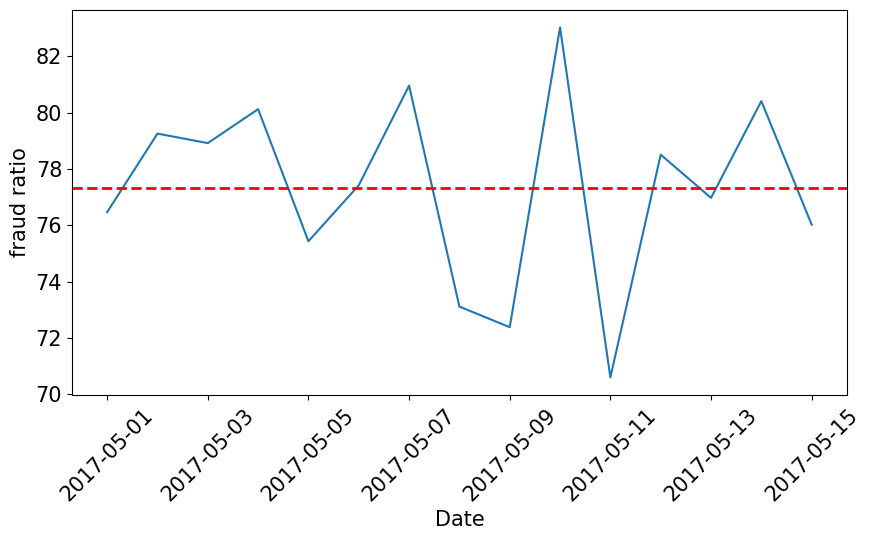

In [90]:
timeline_src1 = src1.groupby('Date').sum().reset_index()
timeline_src1 = timeline_src1.merge(src1_transactions_by_date, how ='left')
timeline_src1['fraud_ratio'] = ((timeline_src1['fraud_label']/timeline_src1['num_transactions']) * 100)
ax = sns.lineplot(x='Date', y='fraud_ratio',data=timeline_src1 )
plt.xticks(rotation=45)
plt.ylabel('fraud ratio')
plt.axhline(timeline_src1['fraud_ratio'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')

[Observation]: Fraud ratio was highest on 2017-5-10 (Wednesday), and lowest on 2017-05-11 (Thursday)

In [93]:
#What are the average fraud transactions for each time stamp of the day? 
# src1['Time'] = src1['Time'].apply(lambda x: x.hour)

# transactions_by_time = src1.groupby('Time').size().reset_index().rename(columns={0:'num_transactions'})
# timeline_src1 = src1.groupby('Time').sum().reset_index()
# timeline_src1 = timeline_src1.merge(transactions_by_time, how ='left')
# timeline_src1['time_fraud_ratio'] = ((timeline_src1['fraud_label']/timeline_src1['num_transactions']) * 100)

# ax = sns.lineplot(x='Time', y='time_fraud_ratio',data=timeline_src1 )
# plt.xticks(rotation=45)
# plt.ylabel('fraud ratio')
# plt.axhline(timeline_src1['time_fraud_ratio'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')

# fig, axs = plt.subplots(figsize=(12, 4))  
# timeline_src1.groupby(timeline_src1["Time"])['time_fraud_ratio'].plot(kind='bar', rot=0, ax=axs)
# plt.xticks(rotation=120)

[Observation]: Plot above corresponds to 24 hour time. Highst average fraud activity happens at 09:00 and lowest at end of day 24:00 

#Take a local time in each country 

### Outlier analysis for continous features for both data sources [FOR REFERENCE ONLY]

Since most variables are categorical, we need another way to analyze outliers 

In [35]:
# src1_outlier = src1.drop(src1_cl, axis=1)
# src1_outlier = src1_outlier.drop(src1_date_time, axis=1)
# src1_outlier = src1_outlier.drop(src1_ip_unique_id, axis=1)

In [36]:
# src2_outlier = src2.drop(src2_cl, axis=1)
# src2_outlier = src2_outlier.drop(src2_date_time, axis=1)
# src2_outlier = src2_outlier.drop(src2_ip_unique_id, axis=1)

In [37]:
#Use IQR technique for detecting outliers 
# def get_num_outliers (column):
#     q1 = np.percentile(column, 25)
#     q3 = np.percentile(column, 75)
#     return sum((column<q1) | (column>q3))

In [38]:
# src1_outlier.groupby('fraud_label').agg([get_num_outliers])

In [39]:
# def remove_outlier_IQR(df):
#     Q1=df.quantile(0.25)
#     Q3=df.quantile(0.75)
#     IQR=Q3-Q1
#     df_outlier=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
#     return df_removed_outlier

#How many outliers in numerical values? Let's use IQR technique to find out
# src1['fraud_label'] = src1['fraud_label'].replace({0:'legit', 1:'fraud'})
# src1_numerical_feat = ['country_cl_source1', 'state_cl_source1', 'city_cl_source1', 'time_zone_source1', 'asn_source1']

# dict_outliers_src1 = {}
# for feat in src1_numerical_feat:
#     df_outlier_removed = remove_outlier_IQR(src1[feat])
#     ind_diff = src1.index.difference(df_outlier_removed.index)
#     dict_outliers_src1[feat] = len(src1) - len(df_outlier_removed)
#     pd_outlier_count_src1 = pd.DataFrame(list(dict_outliers_src1.items()), columns=['feature', '# of outliers'])
# pd_outlier_count_src1.sort_values(ascending=False, by='# of outliers')

In [40]:
#Boxplot visualization
# plt.rcParams["figure.autolayout"] = True

# src1['fraud_label'] = src1['fraud_label'].replace({0:'legit', 1:'fraud'})
# src1_numerical_feat = ['country_cl_source1', 'state_cl_source1', 'city_cl_source1', 'time_zone_source1', 'asn_source1']
# src1_numerical_feat1 = ['country_cl_source1', 'state_cl_source1', 'city_cl_source1']
# src1.boxplot(column=src1_numerical_feat1, by='fraud_label')
# plt.xticks(rotation=90)

# for feat in src1_numerical_feat: 
#     src1.boxplot(column=feat, by='fraud_label')
#     outliers = [flier.get_ydata() for flier in bp["fliers"]]
#     boxes = [box.get_ydata() for box in bp["boxes"]]
#     medians = [median.get_ydata() for median in bp["medians"]]
#     whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

#     print("Outliers: ", outliers)
#     print("Boxes: ", boxes)
#     print("Medians: ", medians)
#     print("Whiskers: ", whiskers)

In [41]:
# plt.rcParams["figure.autolayout"] = True

# src2['fraud_label'] = src2['fraud_label'].replace({0:'legit', 1:'fraud'})
# src2_num_feats = src2.describe().columns.to_list()
# src2.boxplot(column=src2_num_feats, by='fraud_label')
# plt.xticks(rotation=90)

Let's check if there is any data leakage in any of the two sources. Data leakage refers to a mistake that is made by the creator of a machine learning model in which information about the target variable is leaking into the input of the model during the training of the model; information that will not be available in the ongoing data that we would like to predict on.

Unlike over-fitting that we can detect by measuring the differences between the train-validation evaluation metric, data leakage is much more difficult to detect since both your train & validation can achieve great results but the results on the ongoing data will be drastically lower. Identifying the leakage once the model is already deployed in your production environment is not ideal. It would be much for us to identify it in the development stage.



Data Leakage explanation and sources: https://jfrog.com/community/data-science/be-careful-from-data-leakage-2/#:~:text=Data%20leakage%20refers%20to%20a,would%20like%20to%20predict%20on.

Why is data leakage bad? 

### Check for data leakage in cat features 

In [94]:
src1_feat_distribution = src1.copy()
src2_feat_distribution = src2.copy()

In [95]:
src1_feat_distribution = src1.drop(src1_cl, axis=1)
src1_feat_distribution = src1_feat_distribution.drop(src1_date_time, axis=1)
src1_feat_distribution = src1_feat_distribution.drop(src1_ip_unique_id, axis=1)

In [96]:
src1_feat_distribution.head(2)

,fraud_label,continent_source1,country_source1,country_code_source1,state_source1,city_source1,home_source1,connection_type_source1,line_speed_source1,ip_routing_type_source1,organization_type_source1,hosting_facility_source1,anonymizer_status_source1,proxy_type_source1,proxy_level_source1,Date,Time
0,0,north america,united states,us,illinois,chicago,True,ocx,high,fixed,internet service provider,False,NaN,NaN,NaN,2017-05-01,00:00:04.493000
1,1,south america,brazil,br,parana,cianorte,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,2017-05-01,00:00:06.577000


In [97]:
src1_feat_distribution.columns.to_list()

['fraud_label',
 'continent_source1',
 'country_source1',
 'country_code_source1',
 'state_source1',
 'city_source1',
 'home_source1',
 'connection_type_source1',
 'line_speed_source1',
 'ip_routing_type_source1',
 'organization_type_source1',
 'hosting_facility_source1',
 'anonymizer_status_source1',
 'proxy_type_source1',
 'proxy_level_source1',
 'Date',
 'Time']

In [98]:
src2_feat_distribution = src2.drop(src2_cl, axis=1)
src2_feat_distribution = src2_feat_distribution.drop(src2_date_time, axis=1)
src2_feat_distribution = src2_feat_distribution.drop(src2_ip_unique_id, axis=1)

In [99]:
src2_feat_distribution.head(2)

,fraud_label,continent_source2,country_source2,country_code_source2,city_source2,connection_type_source2,organization_type_source2,proxy_is_legitimate_source2,proxy_is_anonymous_source2,proxy_is_anonymous_vpn_source2,proxy_is_hosting_provider_source2,proxy_is_public_source2,proxy_is_tor_source2,Date,Time
0,0,north america,united states,us,chicago,cellular,cellular,0,0,0,0,0,0,2017-05-01,00:00:04.493000
1,1,south america,brazil,br,cianorte,cable/dsl,residential,0,0,0,0,0,0,2017-05-01,00:00:06.577000


In [122]:
#src2
# for n, feat in enumerate(src2_feat_distribution):
#     ax = plt.subplot(10, 2, n + 1)
#     if len(src2_feat_distribution[feat].unique()) < 10:
#         sns.countplot(x=src2_feat_distribution[feat], hue= src2_feat_distribution['fraud_label'], ax=ax)
#         plt.xticks(rotation = 90)
#         plt.show()
#put in a conclusion for each of the categories, use fraud ratios instead of fraud labels 

#In this case, where data is imbalanced, you want to calculate the fraud ratios for each category
# for n, feat in enumerate(src2_feat_distribution.columns):
#     if len(src2_feat_distribution[feat].unique()) < 10:
#         result = src2_feat_distribution.groupby(feat)['fraud_label'].sum().reset_index().apply(lambda x: x/len(src2_feat_distribution))
#         print(result)

# src2_feat_distribution.groupby('continent_source2')['fraud_label'].size()
# src2_feat_distribution['continent_source2'].value_counts()
# src2_feat_distribution.groupby("fraud_label", group_keys=True).apply(lambda x: x)

#Measure fraud ratios for each and every categorical feature
for feat in [src1_feat_distribution.columns][1:]:
    result = src2_feat_distribution.groupby('continent_source2')['fraud_label'].sum().reset_index()
    result['fraud_ratio'] = result['fraud_label'].apply(lambda x: x/len(src2_feat_distribution))
    print(result)


Measure fraud ratios for each and every categorical feature

In [123]:
# #src1
# features_plotted=[]
# for n, feat in enumerate(src1_feat_distribution):
#     ax = plt.subplot(10, 2, n + 1)
#     if len(src1_feat_distribution[feat].unique()) < 10:
#         features_plotted.append(feat)
#         sns.countplot(x=src1_feat_distribution[feat], hue= src1_feat_distribution['fraud_label'], ax=ax )
#         plt.xticks(rotation = 90)
#         plt.show()
# print(features_plotted)

In [50]:
# for n, feat in enumerate(src1_feat_distribution):
#     ax = plt.subplot(3, 2, n + 1)
#     print(f"feature that we are at: {feat}")
#     src1_bin = src1_feat_distribution.fraud_label.count()
#     src1_bin.plot(kind='bar', ax=ax)


In [51]:
#Check if there's are any data leakage in each of the sources, by binning contiounous vars from each d
#datasource 
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
# plt.subplots_adjust(hspace=0.5)

# for n, feat in enumerate(src1_feat_distribution_num):
#     ax = plt.subplot(3, 2, n + 1)
#     print(f"feature that we are at: {feat}")
#     src1_feat_distribution[feat + '_bins'] = pd.cut(src1_feat_distribution_cat[feat], 7) # ADDS BINS, MODIFIES SRC1...
#     src1_bin = src1_feat_distribution.groupby(feat + '_bins').fraud_label.count()
#     src1_bin.plot(kind='bar', ax=ax)
# #     print(src1_bin)

In [52]:
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
# plt.subplots_adjust(hspace=0.5)

# for n, feat in enumerate(src2_numerical_feats):
#     ax = plt.subplot(5, 2, n + 1)
#     src2_feat_distribution[feat + '_bins'] = pd.cut(src2_feat_distribution[feat], 7)
#     src2_bin = src2_feat_distribution.groupby(feat + '_bins').fraud_label.count()
#     src2_bin.plot(kind='bar', ax=ax)
# #     print(src1_bin)

Conclusion: I don't see an obvious indication of data leakage, therefore we can proceed to modeling

## Checking for high correlations between variables [FOR REFERENCE ONLY]

In general, it is recommended to avoid having correlated features in your dataset. Why Multi-Collinearity is a problem? When independent variables are highly correlated, change in one variable would cause change to another and so the model results fluctuate significantly. The model results will be unstable and vary a lot given a small change in the data or model.

In [55]:
# src1_corr = src1[src1_numerical_feats].corr()
# src2_corr = src2[src2_numerical_feats].corr()

In [56]:
# src1_corr

In [57]:
# sns.heatmap(src1_corr)

In [58]:
# sns.heatmap(src2_corr)

In [59]:
# src2_corr

## Checking for intercorrelatinos between

Data leakage can occur for a variety of reasons, often in subtle and difficult-to-detect ways. When data leakage occurs, it usually leads to overly optimistic outcomes during the model building phase, followed by the unpleasant surprise of poor results after the prediction model is implemented and tested on new data. 

https://towardsdatascience.com/data-leakage-in-machine-learning-how-it-can-be-detected-and-minimize-the-risk-8ef4e3a97562

## Check fraud ratio for whole dataset


fraud ratio for dataset
1    0.77522
0    0.22478
Name: fraud_label, dtype: float64


<AxesSubplot: >

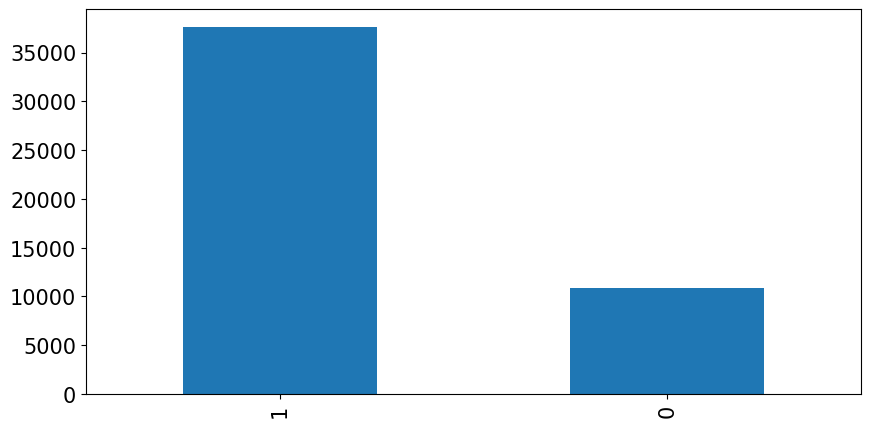

In [56]:
#What is the fraud ratio for the whole dataset? 
print("\nfraud ratio for dataset")
print(src1['fraud_label'].value_counts(normalize=True))
src1['fraud_label'].value_counts().plot(kind='bar')

Data is imbalanced (there are more fraud cases in the dataset than non fraud)

## Feature Engineering

   
1. Get rid correlated variables or combine them (E.g. country, country-code, city, state)
    - https://github.com/rasgointelligence/feature-engineering-tutorials
    - https://github.com/rasgointelligence/feature-engineering-tutorials/blob/main/feature-transformation/time-series/pandas-velocity-acceleration.ipynb


2. Engineer features such as ip address velocity and phone number velocity and plot fraud ratios for them: https://www.chargebackgurus.com/blog/velocity-checks

3. Check to see if we can derive new features such as # of null value count

4. Convert date-time variables to readable formats




In [151]:
#Take only features we need 
src1_final = src1.copy()

#Take out correlated variables like city and state to avoid multi-collinearity
src1_feats_to_include= ['fraud_label',
 'city_source1',
 'home_source1',
 'connection_type_source1',
 'line_speed_source1',
 'ip_routing_type_source1',
 'organization_type_source1',
 'hosting_facility_source1',
 'anonymizer_status_source1',
 'proxy_type_source1',
 'proxy_level_source1',
 'ip_address_hash',
 'phone_number_hash', 
 'Time'
 ]

src1_final = src1[src1_feats_to_include]
src1_final.shape

(48474, 14)

In [149]:
src1_final.columns

Index(['fraud_label', 'city_source1', 'home_source1',
       'connection_type_source1', 'line_speed_source1',
       'ip_routing_type_source1', 'organization_type_source1',
       'hosting_facility_source1', 'anonymizer_status_source1', 'Time',
       'ip_velocity', 'phone_velocity'],
      dtype='object')

In [125]:
#convert time column into hours and ints 
src2['Time'] = src2['Time'].apply(lambda x: x.hour)
src2['Time'].head(2)

0    0
1    0
Name: Time, dtype: int64

In [126]:
src2_final = src2.copy()

src2_feats_to_include = ['fraud_label', 'city_source2', 'connection_type_source2',
       'organization_type_source2', 'proxy_is_legitimate_source2',
       'proxy_is_anonymous_source2', 'proxy_is_anonymous_vpn_source2',
       'proxy_is_hosting_provider_source2', 'proxy_is_public_source2',
       'proxy_is_tor_source2', 'ip_address_hash', 'phone_number_hash', 'Time']
src2_final = src2_final[src2_feats_to_include]

In [127]:
#Engineer velocity features 
  
ip_velocity_src1 = src1_final.groupby(['ip_address_hash', 'fraud_label']).size()
ip_velocity_src1 =ip_velocity_src1.reset_index().rename(columns={0:'count'})
ip_velocity_src1.sort_values(by='count', ascending=False).head(30)

#this plotting takes a really long time - uncomment when you have time to let program load and run
# colors = {'fraud':'red', 'legit':'green'}
# plt.scatter(ip_velocity['ip_address_hash'], ip_velocity['fraud_label'], c=ip_velocity['fraud_label'].map(colors))
# ip_velocity.columns.to_list()
# sns.countplot(data=ip_velocity, x=ip_velocity['ip_address_hash'], hue=ip_velocity['fraud_label'])



,ip_address_hash,fraud_label,count
19016,e5053381f66537df385a1a11fbbd9249,1,28
13854,a6ebccb0fd84ba0d703838aa2c7d3470,1,27
11625,8b9c43b9efcd6d2e429b6cdef7ac4a27,1,26
4329,35007c1fd496fb1c71d0a547fe22b3cd,1,26
7770,5d89d8d1f9a16ebce753b36a299e884e,1,26
511,0657c3b811489103771e813751d82e1f,1,25
3636,2c9bcec1b9fa02dd4f07c590e4e285a6,1,25
425,058b5b49f45c1c9d778ca7b435a05467,1,25
20333,f51d0c574ded165e26532e8242bc1265,1,24
11977,90198d512b58ef4fe44c62c85692a522,1,24


[Observation]:It's clear to me here that a high ip velocity over a one week (8 day) time frame is very indicative of fraud. This makes sense because fraudsters will most likely try to max out their attempts using the same ip address

In [128]:
#phone number velocity: 
pn_velocity_src1 = src1_final.groupby(['phone_number_hash', 'fraud_label']).size()
pn_velocity_src1 =pn_velocity_src1.reset_index().rename(columns={0:'count'})
pn_velocity_src1.sort_values(by='count', ascending=False).head(30)

,phone_number_hash,fraud_label,count
8140,6299995ad8aefcf8a6870ee7e5d3f221,1,20
1587,12cf91042ffd4fc8cf215dd93c0c056d,1,20
20300,f9651a2bf84684e76c65ed47ae274022,1,20
3965,30a4bb013a28a360fcc71ae3327af65f,1,19
15692,bff3c7aecfc6b64369559bb2890458c9,1,18
15667,bf806874cce73d4636a56bc90b5b9f3c,1,18
6097,4a127a2f5d023941a2d8a3125eb919ec,1,18
18293,e0515524f881f97ed6b6d7b42e7d3833,1,18
1488,11a1c95fe9a7028f78ad3577612c35af,1,17
1936,170b0b5c65416f77defc0a8afb23dc8b,1,17


[Observation]: A high phone number velocity is also very indicative of fraud considering that the top 30 phone numbers with the highest velocity are all fraudulent

In [129]:
#Add ip address velocity features to our main dataset
ip_velocity = src1_final.groupby(['ip_address_hash']).size()
ip_velocity = ip_velocity.reset_index().rename(columns={0:'ip_velocity'})

In [130]:
#Add phone velocity feature to our main dataset
pn_velocity = src1_final.groupby(['phone_number_hash']).size()
pn_velocity = pn_velocity.reset_index().rename(columns={0:'phone_velocity'})

In [152]:
#Merge phone velocity and ip address velocity into final src1 dataframe 
src1_final = src1_final.merge(ip_velocity, on='ip_address_hash', how='left')
src1_final = src1_final.merge(pn_velocity, on='phone_number_hash', how='left')
src1_final.head(2)
src1_final.shape

(48474, 16)

In [132]:
#Merge phone velocity and ip address velocity into final src2 dataframe
src2_final = src2_final.merge(ip_velocity, on='ip_address_hash', how='left')
src2_final = src2_final.merge(pn_velocity, on='phone_number_hash', how='left')
src2_final.head(2)


,fraud_label,city_source2,connection_type_source2,organization_type_source2,proxy_is_legitimate_source2,proxy_is_anonymous_source2,proxy_is_anonymous_vpn_source2,proxy_is_hosting_provider_source2,proxy_is_public_source2,proxy_is_tor_source2,ip_address_hash,phone_number_hash,Time,ip_velocity,phone_velocity
0,0,chicago,cellular,cellular,0,0,0,0,0,0,88383218c90dd4b355399a8df04cd54d,a090dcb8615eb80cfc6782092a598352,0,1,1
1,1,cianorte,cable/dsl,residential,0,0,0,0,0,0,730baa254a10bb2c8fb1c9e72ecbbdbe,a6fbb057e5a85f6c9fea7216a84859dd,0,1,1


Since a vacant 'anonymizer_status' field means that an ip address was not used with a proxy within the last 60 days, we can consider this fact as a feature

In [133]:
#Convert null values from anonymizer source into a dataframe 
src1_final['anonymizer_status_source1'] = src1_final['anonymizer_status_source1'].replace(np.nan, 'NOT FOUND')
src1_final.head(2)

,fraud_label,city_source1,home_source1,connection_type_source1,line_speed_source1,ip_routing_type_source1,organization_type_source1,hosting_facility_source1,anonymizer_status_source1,proxy_type_source1,proxy_level_source1,ip_address_hash,phone_number_hash,Time,ip_velocity,phone_velocity
0,0,chicago,True,ocx,high,fixed,internet service provider,False,NOT FOUND,NaN,NaN,88383218c90dd4b355399a8df04cd54d,a090dcb8615eb80cfc6782092a598352,00:00:04.493000,1,1
1,1,cianorte,NaN,NaN,NaN,NaN,NaN,False,NOT FOUND,NaN,NaN,730baa254a10bb2c8fb1c9e72ecbbdbe,a6fbb057e5a85f6c9fea7216a84859dd,00:00:06.577000,1,1


In [153]:
#dropping unique ids from our training dataset, and values with majority null values 
src1_final.drop(['ip_address_hash', 'phone_number_hash','proxy_type_source1', 'proxy_level_source1'], axis=1, inplace=True)
src1_final.shape

(48474, 12)

In [156]:
#Check number of null values in each column before dropping all null values before procceeding to the next stage 
src1_final.isna().sum().sort_values(ascending=False)


fraud_label                  0
city_source1                 0
home_source1                 0
connection_type_source1      0
line_speed_source1           0
ip_routing_type_source1      0
organization_type_source1    0
hosting_facility_source1     0
anonymizer_status_source1    0
Time                         0
ip_velocity                  0
phone_velocity               0
dtype: int64

In [155]:
#handle null values in dataframe 

src1_final.dropna(inplace=True)
src2_final.dropna(inplace=True)
src1_final.shape

(3374, 12)

## Building Model

##### In this section we are going to conduct research regarding the predictive power of the IP data (from the sample mentioned above) for the fraud detection problem (i.e. predictive power regarding the target variable fraud label)
- Examing feature importances 
        https://github.com/rasgointelligence/feature-engineering-tutorials/blob/main/feature-importance/Catboost%20Feature%20Importance.ipynb
- Oversampling/Undersampling to acheive a balanced data set
- Using supervised learning techniques and evaluating results of overlapping both src1 and src2/only using one datasource
- Hyperparameter tuning https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/
    

#### Imports

In [139]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor, Pool
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE

#### Divide data into training and testing

In [141]:
src1_y = src1_final['fraud_label']
src1_x = src1_final.drop('fraud_label', axis=1)
src1_X_train, src1_X_test, src1_y_train, src1_y_test = train_test_split(src1_x, src1_y, 
                                                                        test_size=.2, random_state=1066) #set random state seed so that we can replicate results 
src1_X_train.shape, src1_X_test.shape, src1_y_train.shape, src1_y_test.shape

((27719, 11), (6930, 11), (27719,), (6930,))

In [138]:
src2_y = src2_final['fraud_label']
src2_x = src2_final.drop('fraud_label', axis=1)
src2_X_train, src2_X_test, src2_y_train, src2_y_test = train_test_split(src2_x, src2_y, 
                                                                        test_size=.2, random_state=1066)

### Investigate Feature Importances using CatBoost Regressor

CatBoost builds upon the theory of decision trees and gradient boosting. The main idea of boosting is to sequentially combine many weak models (a model performing slightly better than random chance) and thus through greedy search create a strong competitive predictive model

source: https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

Why use catboost regressor over random forest? Why not use XGBoost? What is the difference between random forest and decision trees? 

In [81]:
#importing library and building model
categorical_features_indices = np.where(src1_x.dtypes != np.float)[0]
model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(src1_X_train, src1_y_train,cat_features=categorical_features_indices,eval_set=(src1_X_test, src1_y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3742510	test: 0.3771624	best: 0.3771624 (0)	total: 74.6ms	remaining: 3.66s
1:	learn: 0.3480932	test: 0.3500361	best: 0.3500361 (1)	total: 79.7ms	remaining: 1.91s
2:	learn: 0.3248067	test: 0.3258209	best: 0.3258209 (2)	total: 87.7ms	remaining: 1.37s
3:	learn: 0.3046897	test: 0.3047788	best: 0.3047788 (3)	total: 91.7ms	remaining: 1.05s
4:	learn: 0.2877161	test: 0.2868981	best: 0.2868981 (4)	total: 96ms	remaining: 864ms
5:	learn: 0.2729803	test: 0.2713411	best: 0.2713411 (5)	total: 99.3ms	remaining: 728ms
6:	learn: 0.2601611	test: 0.2577426	best: 0.2577426 (6)	total: 103ms	remaining: 630ms
7:	learn: 0.2492367	test: 0.2461372	best: 0.2461372 (7)	total: 105ms	remaining: 553ms
8:	learn: 0.2400626	test: 0.2362520	best: 0.2362520 (8)	total: 108ms	remaining: 493ms
9:	learn: 0.2322774	test: 0.2278604	best: 0.2278604 (9)	total: 113ms	remaining: 451ms
10:	learn: 0.2259938	test: 0.2209946	best: 0.2209946 (10)	total: 116ms	remaining: 412ms
11:	learn: 0.2206886	test: 0.2151873	best: 0.215

Catboost regressor performs best with a tree-count of 49. 

Text(0.5, 1.0, 'Feature Importance')

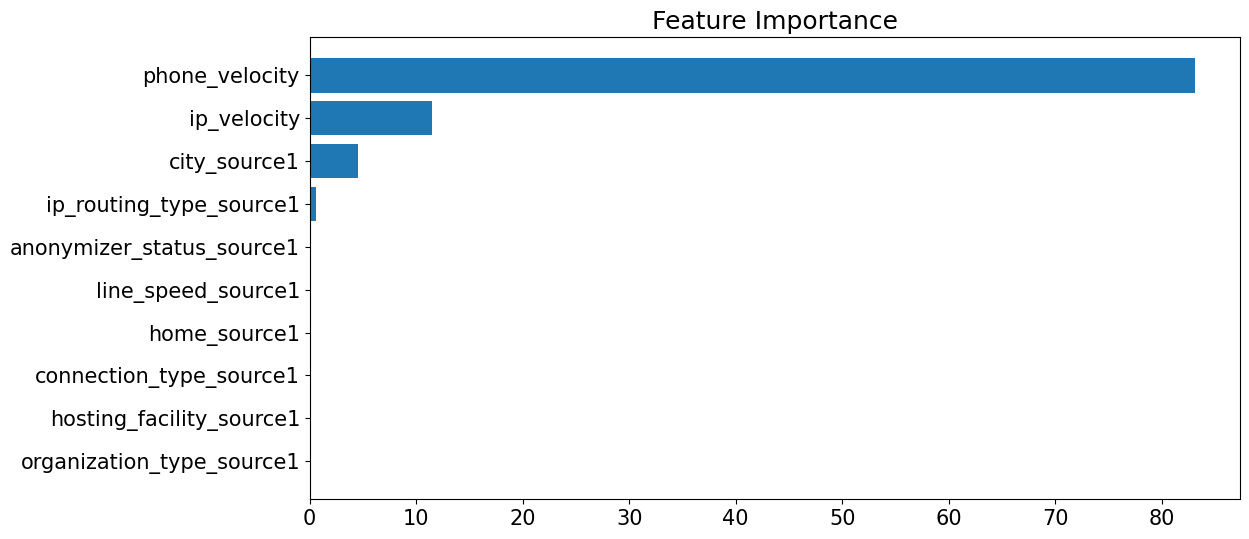

In [89]:
#plot tree-based (or Gini) importance 
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(src1_X_test.columns)[sorted_idx])
plt.title('Feature Importance')


[Observation]: The results above make sense because a fraudster will often experiment with one fraudulent transaction to see if a card will work. If it passes through your system without raising any internal flags, a multitude of orders will most likely be purchased until the card is maxed out.
Typical data elements used for velocity are the email address, phone number, credit card number, billing address and shipping address. Name does not work very well because there could be multiple people with the same name and this could affect good customers in the process.

In [82]:
#repeat for src2: 
categorical_features_indices = np.where(src2_x.dtypes != np.float)[0]
model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(src2_X_train, src2_y_train,cat_features=categorical_features_indices,eval_set=(src2_X_test, src2_y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3849698	test: 0.3815931	best: 0.3815931 (0)	total: 6.78ms	remaining: 332ms
1:	learn: 0.3579291	test: 0.3549413	best: 0.3549413 (1)	total: 15.7ms	remaining: 376ms
2:	learn: 0.3345895	test: 0.3318587	best: 0.3318587 (2)	total: 19.6ms	remaining: 307ms
3:	learn: 0.3140788	test: 0.3117011	best: 0.3117011 (3)	total: 22.7ms	remaining: 261ms
4:	learn: 0.2964461	test: 0.2943838	best: 0.2943838 (4)	total: 29.3ms	remaining: 264ms
5:	learn: 0.2814391	test: 0.2796201	best: 0.2796201 (5)	total: 33.1ms	remaining: 242ms
6:	learn: 0.2685456	test: 0.2669904	best: 0.2669904 (6)	total: 37.2ms	remaining: 228ms
7:	learn: 0.2577813	test: 0.2565047	best: 0.2565047 (7)	total: 40ms	remaining: 210ms
8:	learn: 0.2484963	test: 0.2474512	best: 0.2474512 (8)	total: 42.8ms	remaining: 195ms
9:	learn: 0.2407761	test: 0.2399136	best: 0.2399136 (9)	total: 46.4ms	remaining: 186ms
10:	learn: 0.2345429	test: 0.2338099	best: 0.2338099 (10)	total: 49.7ms	remaining: 176ms
11:	learn: 0.2291102	test: 0.2285268	best: 

Text(0.5, 1.0, 'Feature Importance')

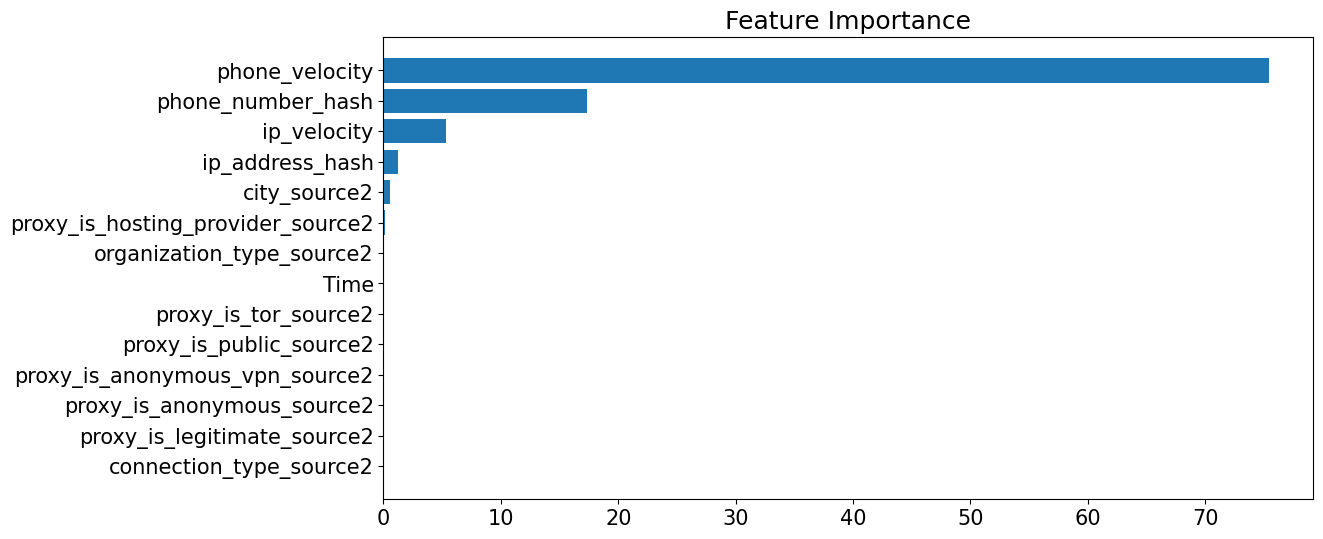

In [83]:
#plot tree-based (or Gini) importance 
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(src2_X_test.columns)[sorted_idx])
plt.title('Feature Importance')

#### Encode Variables 


Since most of the variables in our training data are categorical, we need to encode our variables in order to use them for fitting our models 
- Categorical encoding: 
- Since we have high cardinality categorical variables (e.g city), we can also try target encoding. “features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.” https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64#:%7E:text=%E2%80%9Cfeatures%20are%20replaced%20with%20a,over%20all%20the%20training%20data.%E2%80%9D


In [164]:
src1_x_cat = src1_x.select_dtypes(exclude=np.number) #change this line - use dtypes() instead
#If data is sparse, make sure that your categorical vars does not turn into categorical vars 

pandas.core.frame.DataFrame

In [165]:
src2_x_cat = src2_x.select_dtypes(exclude=np.number)
src2_x_cat.columns

Index(['city_source2', 'connection_type_source2', 'organization_type_source2',
       'ip_address_hash', 'phone_number_hash'],
      dtype='object')

### Pros and Cons of Encoding: https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/

Challenges with Label Encoding
In the above scenario, the Country names do not have an order or rank. But, when label encoding is performed, the country names are ranked based on the alphabets. Due to this, there is a very high probability that the model captures the relationship between countries such as India < Japan < the US.

This is something that we do not want! So how can we overcome this obstacle? Here comes the concept of One-Hot Encoding.

Challenges of One-Hot Encoding: Dummy Variable Trap
One-Hot Encoding results in a Dummy Variable Trap as the outcome of one variable can easily be predicted with the help of the remaining variables.

The Dummy Variable Trap leads to the problem known as multicollinearity. Multicollinearity occurs where there is a dependency between the independent features. Multicollinearity is a serious issue in machine learning models like Linear Regression and Logistic Regression.

So, in order to overcome the problem of multicollinearity, one of the dummy variables has to be dropped. Here, I will practically demonstrate how the problem of multicollinearity is introduced after carrying out the one-hot encoding.

### When to use a Label Encoding vs. One Hot Encoding
This question generally depends on your dataset and the model which you wish to apply. But still, a few points to note before choosing the right encoding technique for your model:

##### We apply One-Hot Encoding when:

The categorical feature is not ordinal (like the countries above)
The number of categorical features is less so one-hot encoding can be effectively applied

##### We apply Label Encoding when:

The categorical feature is ordinal (like Jr. kg, Sr. kg, Primary school, high school)
 The number of categories is quite large as one-hot encoding can lead to high memory consumption



In [167]:
from sklearn.preprocessing import LabelEncoder

#econde categorical variables in src1 
labelencoder = LabelEncoder()
src1_X_tr = src1
for cat in src1_x_cat: 
    src1_X_train[cat + '_encode']=labelencoder.fit_transform(src1_X_train[cat])

src1_X_train=src1_X_train.drop(src1_x_cat, axis=1)

In [168]:
#econde categorical variables in src2
for cat in src2_x_cat: 
    src2_X_train[cat + '_encode']=labelencoder.fit_transform(src2_X_train[cat])

src2_X_train=src2_X_train.drop(src2_x_cat, axis=1)

In [178]:
col_list = src1_X_train.columns.to_list()
src1_X_train.columns = [x.replace('_encode','') for x in col_list]

col_list = src2_X_train.columns.to_list()
src2_X_train.columns = [x.replace('_encode','') for x in col_list]

#### SMOTE oversampling to balance data

<AxesSubplot: >

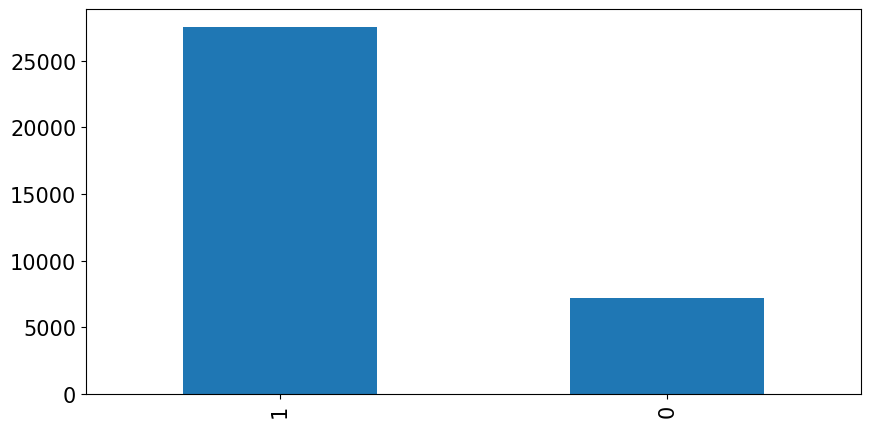

In [179]:
src1_y.value_counts()
src1_y.value_counts().plot(kind='bar')

Important Note: 
If you are going to use SMOTE, it should only be applied to the training data. This is because you are using SMOTE to gain an improvement in operational performance, and both the validation and test sets are there to provide an estimate of operational performance.Jan 

In [180]:
#Oversampling the data

smote = SMOTE(random_state = 101)
src1_X_resampled_train, src1_y_resample_train = smote.fit_resample(src1_X_train, src1_y_train)

In [181]:
src2_X_resampled_train, src2_y_resampled_train = smote.fit_resample(src2_X_train, src2_y_train)

<AxesSubplot: >

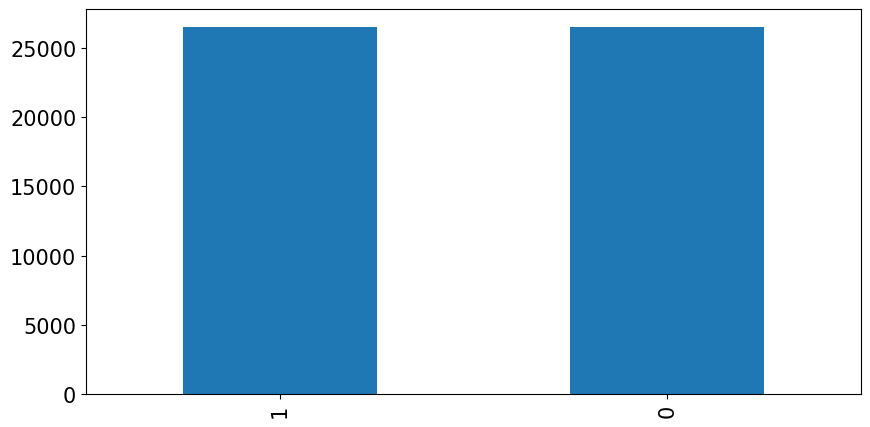

In [182]:
src2_y_resampled_train.value_counts().plot(kind='bar')

## Train/Fit models and evaluate on both datasets separately and experiment with combined dataset 

Before building a classification model, let’s build a Dummy Classifier to determine the ‘baseline’ performance. This answers the question — ‘What would be the success rate of the model, if one were simply guessing?’ The dummy classifier we are using will simply predict the majority class.

#### Train evaluate a logistic regression model on 2 datasources individually

In [184]:
#Let's fit a baseline model
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy= 'most_frequent').fit(src1_X_resampled_train,src1_y_resample_train)
y_pred = clf.predict(src1_X_test)


In [185]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(src1_y_test,y_pred)))
print('Precision Score : ' + str(precision_score(src1_y_test,y_pred)))
print('Recall Score : ' + str(recall_score(src1_y_test,y_pred)))
print('F1 Score : ' + str(f1_score(src1_y_test,y_pred)))

#Dummy Classifier Confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix : \n' + str(confusion_matrix(src1_y_test,y_pred)))

Accuracy Score : 0.2111111111111111
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0
Confusion Matrix : 
[[1463    0]
 [5467    0]]


In [187]:
src1_X_resampled_train.columns.to_list()


['ip_velocity',
 'phone_velocity',
 'city_source1',
 'home_source1',
 'connection_type_source1',
 'line_speed_source1',
 'ip_routing_type_source1',
 'organization_type_source1',
 'hosting_facility_source1',
 'anonymizer_status_source1',
 'Time']

In [188]:
src1_X_test.columns.to_list()

['city_source1',
 'home_source1',
 'connection_type_source1',
 'line_speed_source1',
 'ip_routing_type_source1',
 'organization_type_source1',
 'hosting_facility_source1',
 'anonymizer_status_source1',
 'Time',
 'ip_velocity',
 'phone_velocity']

In [186]:
#Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')
grid_clf_acc.fit(src1_X_resampled_train,src1_y_resample_train)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(src1_X_test)
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(src1_y_test,y_pred)))
print('Precision Score : ' + str(precision_score(src1_y_test,y_pred)))
print('Recall Score : ' + str(recall_score(src1_y_test,y_pred)))
print('F1 Score : ' + str(f1_score(src1_y_test,y_pred)))
confusion_matrix(src1_y_test,y_pred_acc)

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.
